## I have docked using
1. asap-docking 
2. autodock-vina structures
   (has some docking scores from autodock-vina call vina_affinity, vina_rmsd_lb, vina_rmsd_ub)

#### After the docking, try to evaluate if interactions are the same or retained to matching aligned residue postion using plip or other methods

In [3]:
import os
import re
from pathlib import Path
from rdkit import Chem
import oddt
from oddt.docking.AutodockVina import *
from asapdiscovery.data.backend.openeye import load_openeye_pdb, load_openeye_sdf, save_openeye_sdf
from openeye import oechem
import matplotlib.pyplot as plt

In [4]:
# Return a list of all the files in input directory and and layered directory inside
def traverse_files(directory):
    all_files = []
    # Traverse files within a directory
    for root, dirs, files in os.walk(directory):
        for file in files:
            all_files.append(file)
    return all_files

## Batch Redock asap-docking

### I am just going to loop through the prepped cache files and generate a new command line each time since each of these structures would be referenced to different starting positions (since not docking to the same place)

### This did not work see: https://github.com/choderalab/asapdiscovery/issues/960

In [ ]:
command = 'asap-docking cross-docking --target ZIKV-NS2B-NS3pro'

cache_command = '--cache-dir'
file_command = '--pdb-file'
output_command = '--output-dir'
lig_command = '--ligands'

dask_command = ' --use-dask'
append = '--use-only-cache --structure-selector PairwiseSelector'


In [ ]:
# List of protein names
prots = []
prots_dir = '/home/pengs/fold_zika/only_prot'
prot_files = traverse_files(prots_dir)
for file in prot_files:
    name = Path(file).stem
    prots.append(name)
prots

In [ ]:
prepped_dir = '/home/pengs/fold_zika/prev_prepped'
output_all_dir = '/home/pengs/fold_zika/dock-asap/dock_by_asap'

In [ ]:
run_file = Path("/home/pengs/fold_zika/dock-asap")
with open(run_file/'dock_files.sh','w') as f:
    f.write('#!/bin/bash\n')
    f.write('\n')
    for prot in prots:
        prep_folder = prot + '_prepped'
        prot_path = os.path.join(prepped_dir, prep_folder)
    
        # The protein structure file
        pdb_file = os.path.join(prots_dir, prot + '.pdb')
    
        # Output directory
        output_dir = os.path.join(output_all_dir, prot)
    
        dirs = os.listdir(prot_path)
        for d in dirs:
            d_path = os.path.join(prot_path,d)
            if os.path.isfile(d_path):
                break

            for root, dirs, files in os.walk(d_path):
                for direct in dirs:
                    # This is where all the prepped strucuture are stored in the directory
                    cache_folder = os.path.join(root,direct)
                for file in files:
                    if file.endswith('.json'):
                        if file == 'protein_prep.json':
                            break
                        else:
                            cache_json = os.path.join(root, file)

                    if file.endswith('.smi'):
                        smi_path = os.path.join(root, file)
    
    
                    # write into Command Format
                    cmd = command
                    # cache
                    cmd += ' ' + cache_command + ' ' + cache_json
                    # protein to dock to
                    cmd += ' ' + file_command + ' ' + pdb_file
                    # output directory
                    cmd += ' ' + output_command + ' ' + output_dir
                    # ligand to dock
                    cmd += ' ' + lig_command + ' ' + smi_path
                    # include to force docking to work
                    cmd += ' ' + append + '\n'
                    
                    f.write(cmd)

asap-docking cross-docking --target ZIKV-NS2B-NS3pro --cache-dir /home/pengs/fold_zika/prev_prepped/YP_001621843.1_prepped/YP_001621843.1_lig_9/YP_001621843.1_lig_9-8d7ddb0e1e4069c3ee7f2e326362efc09005743055c1e6d13939474fe229e295+ABOZUPQQWCLVDB-WLIIHVBTNA-O/YP_001621843.1_lig_9.json --pdb-file /home/pengs/fold_zika/only_prot/YP_001527884.1.pdb --output-dir /home/pengs/fold_zika/dock-asap/dock_by_asap/YP_001527884.1 --ligands /home/pengs/fold_zika/prev_prepped/YP_001621843.1_prepped/YP_001621843.1_lig_9/YP_001621843.1_lig_9-8d7ddb0e1e4069c3ee7f2e326362efc09005743055c1e6d13939474fe229e295+ABOZUPQQWCLVDB-WLIIHVBTNA-O/YP_001621843.1_lig_9_ligand.smi --use-only-cache --structure-selector PairwiseSelector

## Batch Redock using AutodockVina
https://oddt.readthedocs.io/en/latest/rst/oddt.docking.html#module-oddt.docking.AutodockVina

https://vina.scripps.edu/manual/#output

In [3]:
from oddt.toolkits.extras.rdkit.fixer import PrepareComplexes, ExtractPocketAndLigand, PreparePDBMol
from rdkit import Chem

### I think Autodock Vina already does a bunch of prepping using accessory files
https://www.cgl.ucsf.edu/chimera/docs/ContributedSoftware/vina/vina.html
#### But for visualization and simplicity sake, I made all implicit Hydrogen explicit in the ligand to dock

In [ ]:
# Add explicit hydrogen to all the ligands
lig_dir = Path("/home/pengs/fold_zika/lig_sdfs/")
lig_h_dir = Path("/home/pengs/fold_zika/lig_h_sdfs/")

In [ ]:
lig = load_openeye_sdf(lig_dir/'lig_0.sdf')
lig_h = oechem.OEAddExplicitHydrogens(lig)
save_openeye_sdf(lig, lig_dir/'lig_0_h.sdf')

In [ ]:
# List of protein names
lig_files = traverse_files(lig_dir)
for file in lig_files:
    name = Path(file).stem
    lig = load_openeye_sdf(lig_dir/file)
    # Add the hydrogen
    lig_h = oechem.OEAddExplicitHydrogens(lig)
    # Save ligand with hydrogen
    new_file = name + '_h.sdf'
    save_openeye_sdf(lig, lig_h_dir/new_file)

## WORKFLOW
1. read in each of the colabfold generated structure
2. read in each ligand
3. Dock each combination with autodock vina
4. Save docked ligand poses from one protein and one ligand into a directory

In [8]:
prots_dir = Path('/home/pengs/fold_zika/only_prot')
output_dir = Path('/home/pengs/fold_zika/oddt_dock/output')

In [ ]:
# Go through each protein
prot_files = traverse_files(prots_dir)
for prot_file in prot_files:
    file = prots_dir/prot_file
    protein = next(oddt.toolkit.readfile('pdb', str(file)))
    protein.protein = True

    # Make directory to save the docked poses into
    name = Path(file).stem
    save_dir = output_dir/name
    print(save_dir)
    #os.mkdir(save_dir)
    
    # Go through each ligand
    lig_files = traverse_files(lig_h_dir)
    for lig_file in lig_files:
        print(lig_file)
        ligand = next(oddt.toolkit.readfile('sdf', str(lig_h_dir/lig_file)))
        # Ligand use to center the docking box defined in the docking object
        vina = autodock_vina(auto_ligand = str(lig_h_dir/lig_file))
        dock_ligs = vina.dock(protein = protein, ligands = ligand)
        # Save the different docked poses of the ligand 
        for i in range(len(dock_ligs)):
            write_vina_pdbqt(dock_ligs[i], save_dir,name_id=i)

## Actual Script used:
/home/pengs/notebook/oddt_dock.py

/home/pengs/fold_zika/oddt_dock/oddt_dock_job.sh

## Now figure out which of the oddt generated poses to keep
1. run plip with protein and ligand and rank based on plip score
2. compare plip score with vina affinity score
3. get the active site residue of top rank poses
4. compare to msa of canonical number of the residue
5. see if the residue is the aligned (or nearby) or original interaction
6. see if the residue that aligned (or is nearby) has the same interaction

In [2]:
from asapdiscovery.data.backend.plip import get_interactions_plip, compute_fint_score
import subprocess
import json
import re
from scipy.spatial import distance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pds

/home/pengs/miniconda3/envs/oddt/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/pengs/miniconda3/envs/oddt/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/pengs/miniconda3/envs/oddt/lib/python3.10/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/pengs/miniconda3/envs/oddt/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


### Convert .pdbqt to .pdb file:
cut -c-66 0_lig_0.pdbqt > ../0_lig_0.pdb

## Save the plip interactions identified into a dictionary of dictionaries
outer layer protein, inner layer ligand

In [8]:
prots_dir = Path('/home/pengs/fold_zika/only_prot')
poses_dir = Path('/home/pengs/fold_zika/oddt_dock/output')
pdb_poses_dir = Path('/home/pengs/fold_zika/oddt_dock/pose_pdbs')
target = 'ZIKV-NS2B-NS3pro'

# Dictionary to save everything in
plip_oddt_docked = dict()
fint_oddt_docked = dict()

In [9]:
# Go through each protein
prot_files = traverse_files(prots_dir)
for prot_file in prot_files:
    # Protein name 
    name = Path(prot_file).stem
    if name == 'zikv_ns2b3':
        continue
    # Initiate sub-dictionary for the protein
    plip_oddt_docked[name] = dict()
    fint_oddt_docked[name] = dict()
    
    # Directory with docked poses
    docked_dir = poses_dir/name
    save_pdb_dir = pdb_poses_dir/name
    print(docked_dir)
    #os.mkdir(save_pdb_dir)
    
    #Go through each ligand that start with '0_' becaust that is the one that has the best docking score
    lig_files = os.listdir(docked_dir)
    top_lig_files = [file for file in lig_files if file.startswith('0_')]
    
    for lig_file in top_lig_files:
        new_file = Path(lig_file).stem + '.pdb'
        # Save in dictionary with the number label the ligand with
        lig_num_pattern = r'0_lig_(\d+).'
        match = re.search(lig_num_pattern, lig_file)
        lig_num = match.group(1)
        # Convert the pdbqt files to pdb to be read by openeye
        cmd = f"cut -c-66 {docked_dir}/{lig_file} > {save_pdb_dir}/{new_file}"
        subprocess.run(cmd, shell=True)
        # Read in the pdb files to openeye to get plip
        prot = load_openeye_pdb(f'{prots_dir}/{prot_file}')
        lig = load_openeye_pdb(f'{save_pdb_dir}/{new_file}')
        # Get plip
        #plip = get_interactions_plip(prot, lig, 'fitness',target)
        fint_score = compute_fint_score(prot, lig,target)
        # Save this in the dictionary under the ligand name
        #plip_oddt_docked[name][lig_num] = plip
        fint_oddt_docked[name][lig_num] = fint_score

/home/pengs/fold_zika/oddt_dock/output/NP_776018.1


2024-04-15 16:54:18,466 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 16:54:18,467 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-15 16:54:18,467 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-15 16:54:18,467 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-15 16:54:18,659 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5318562.tmpdir/tmp93q0mvut/
2024-04-15 16:54:19,901 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 16:54:19,902 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

/home/pengs/fold_zika/oddt_dock/output/YP_001527884.1


2024-04-15 16:55:45,126 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 16:55:45,127 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-15 16:55:45,127 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-15 16:55:45,127 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-15 16:55:45,195 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5318562.tmpdir/tmpq57saf1v/
2024-04-15 16:55:46,373 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 16:55:46,374 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

/home/pengs/fold_zika/oddt_dock/output/YP_001531172.2


2024-04-15 16:57:14,721 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 16:57:14,722 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-15 16:57:14,722 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-15 16:57:14,723 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-15 16:57:14,790 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5318562.tmpdir/tmp0fyhs5w_/
2024-04-15 16:57:15,799 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 16:57:15,800 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

/home/pengs/fold_zika/oddt_dock/output/NP_739587.2


2024-04-15 16:58:42,935 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 16:58:42,936 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-15 16:58:42,936 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-15 16:58:42,936 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-15 16:58:43,001 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5318562.tmpdir/tmptw64pxe2/
2024-04-15 16:58:43,975 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 16:58:43,976 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

/home/pengs/fold_zika/oddt_dock/output/NP_722463.1


2024-04-15 17:00:11,378 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 17:00:11,379 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-15 17:00:11,380 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-15 17:00:11,380 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-15 17:00:11,446 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5318562.tmpdir/tmpy1uq0xiw/
2024-04-15 17:00:12,451 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 17:00:12,451 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

/home/pengs/fold_zika/oddt_dock/output/NP_740321.1


2024-04-15 17:01:40,597 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 17:01:40,598 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-15 17:01:40,598 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-15 17:01:40,599 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-15 17:01:40,668 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5318562.tmpdir/tmp4su5bytx/
2024-04-15 17:01:41,869 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 17:01:41,870 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

/home/pengs/fold_zika/oddt_dock/output/YP_001621843.1


2024-04-15 17:03:10,506 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 17:03:10,507 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-15 17:03:10,508 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-15 17:03:10,508 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-15 17:03:10,588 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5318562.tmpdir/tmpevs240ur/
2024-04-15 17:03:11,650 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-15 17:03:11,651 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

In [10]:
# Save dictionary into json
#with open('/home/pengs/fold_zika/oddt_dock/plip.json', 'w') as f:
#    json.dump(plip_oddt_docked, f)
## Read in the json for big dictionary
# Save dictionary into json
with open('/home/pengs/fold_zika/oddt_dock/fint_oddt.json', 'w') as f:
    json.dump(fint_oddt_docked, f)

## Read in the json for big dictionary
#plip_oddt_docked = dict()
#with open('/home/pengs/fold_zika/oddt_dock/plip.json', 'r') as f:
#    plip_oddt_docked = json.load(f)
#fint_oddt_docked = dict()
#with open('/home/pengs/fold_zika/oddt_dock/fint_oddt.json', 'r') as f:
#    fint_oddt_docked = json.load(f)

### Plip interaction of originally bound structure

In [49]:
orig_bind = Path('/home/pengs/fold_zika/test_prep/orig_bind')
ligs_dir = Path('/home/pengs/fold_zika/lig_h_sdfs')
prot_file = Path('/home/pengs/fold_zika/test_prep/zikv_ns2b3.pdb')
target = 'ZIKV-NS2B-NS3pro'
orig_interacts = dict()
orig_fint = dict()

In [52]:
prot = load_openeye_pdb(prot_file)
lig_files = os.listdir(ligs_dir)

for lig_file in lig_files:
    # Save in dictionary with the number label the ligand with
    lig_num_pattern = r'lig_(\d+)_h.'
    match = re.search(lig_num_pattern, lig_file)
    lig_num = match.group(1)

    # Load in the ligand into openeye
    lig = load_openeye_sdf(f'{ligs_dir}/{lig_file}')
    # Get plip
    plip = get_interactions_plip(prot, lig, 'fitness',target)
    fint_score = compute_fint_score(prot, lig,target)
    # Save this in the dictionary under the ligand name
    orig_interacts[lig_num] = plip
    orig_fint[lig_num] = fint_score

2024-04-17 14:06:09,237 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:06:09,237 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:06:09,238 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:06:09,238 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:06:09,450 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp_bfq6s1p/
2024-04-17 14:06:10,525 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:06:10,526 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

2024-04-17 14:06:21,390 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:06:21,390 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:06:21,390 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:06:21,390 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:06:21,604 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp_6pza6i_/
2024-04-17 14:06:22,790 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:06:22,790 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

2024-04-17 14:06:33,736 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:06:33,736 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:06:33,736 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:06:33,736 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:06:33,939 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpqsq46dwr/
2024-04-17 14:06:34,265 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:06:34,266 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

2024-04-17 14:06:42,226 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpq1553e6g/
2024-04-17 14:06:42,553 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:06:42,553 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:06:42,553 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:06:42,553 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:06:42,758 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp9vhi3upi/
/home/pengs/miniconda3/envs/oddt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarn

2024-04-17 14:06:50,686 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpy5q2i4gg/
2024-04-17 14:06:51,307 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:06:51,307 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:06:51,307 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:06:51,307 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:06:51,515 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpcpy369ed/
2024-04-17 14:06:52,125 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 

2024-04-17 14:07:01,096 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp4cld03g0/
2024-04-17 14:07:01,391 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:07:01,391 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:07:01,391 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:07:01,391 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:07:01,597 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp4ts6b34c/
/home/pengs/miniconda3/envs/oddt/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarn

2024-04-17 14:07:10,626 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpnfgttahz/
2024-04-17 14:07:11,520 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:07:11,520 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:07:11,520 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:07:11,520 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:07:11,730 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp3pr9u043/
2024-04-17 14:07:12,595 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 

2024-04-17 14:07:21,513 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpczfzkvyz/
2024-04-17 14:07:22,133 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:07:22,133 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:07:22,133 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:07:22,133 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:07:22,342 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp90w1tat1/
2024-04-17 14:07:22,917 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 

2024-04-17 14:07:32,723 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpxj64inob/
2024-04-17 14:07:33,636 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:07:33,636 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:07:33,636 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:07:33,636 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:07:33,876 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp1jyzk2r4/
2024-04-17 14:07:35,158 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 

2024-04-17 14:07:45,802 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmplfeetf_o/
2024-04-17 14:07:46,845 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:07:46,845 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:07:46,845 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:07:46,845 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:07:47,070 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp7ao9k5ao/
2024-04-17 14:07:48,125 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 

2024-04-17 14:07:59,617 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp9y876p9a/
2024-04-17 14:08:00,335 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:08:00,336 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:08:00,336 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:08:00,336 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:08:00,541 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp73kl8x0j/
2024-04-17 14:08:01,014 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 

2024-04-17 14:08:10,530 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpdxuvm9p7/
2024-04-17 14:08:11,016 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:08:11,016 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:08:11,016 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:08:11,016 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:08:11,223 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpcjpf04eu/
2024-04-17 14:08:11,706 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 

2024-04-17 14:08:21,820 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmppvd7ppqy/
2024-04-17 14:08:22,611 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:08:22,612 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:08:22,612 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:08:22,612 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:08:22,822 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp42h1l2a0/
2024-04-17 14:08:23,887 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 

2024-04-17 14:08:40,160 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpv1_7gt1z/
2024-04-17 14:08:41,369 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:08:41,370 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:08:41,370 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:08:41,370 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:08:41,581 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpnf6nguox/
2024-04-17 14:08:42,569 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 

2024-04-17 14:08:57,176 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmp6cbkp6qj/
2024-04-17 14:08:58,620 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-17 14:08:58,620 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-17 14:08:58,620 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-17 14:08:58,620 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-17 14:08:58,845 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5496017.tmpdir/tmpnaimdddu/
2024-04-17 14:08:59,673 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 

In [53]:
# Save dictionary into json
with open('/home/pengs/fold_zika/oddt_dock/orig_plip.json', 'w') as f:
    json.dump(orig_interacts, f)
with open('/home/pengs/fold_zika/oddt_dock/orig_fint.json', 'w') as f:
    json.dump(orig_fint, f)

## Read in from before

In [3]:
## Read in the json for big dictionary
orig_interacts = dict()
with open('/home/pengs/fold_zika/oddt_dock/orig_plip.json', 'r') as f:
    orig_interacts = json.load(f)
## Read in the json for big dictionary
plip_oddt_docked = dict()
with open('/home/pengs/fold_zika/oddt_dock/plip.json', 'r') as f:
    plip_oddt_docked = json.load(f)

In [4]:
# Get a list of all the generated structure
docked_prots = list(plip_oddt_docked.keys())
docked_prots

['NP_776018.1',
 'YP_001527884.1',
 'YP_001531172.2',
 'NP_739587.2',
 'NP_722463.1',
 'NP_740321.1',
 'YP_001621843.1']

In [18]:
# Put them all into one dict
plip_all = plip_oddt_docked
plip_all['zikv_ns2b3'] = orig_interacts

## Now would like to read in the MSA results and compare the residues identified in the interaction and compare using canonical number 
### Loop through each of the ligands and get the interaction preservation of each

In [19]:
# Read in the MSA mapping of canonical number to pdb residue id
msa_map = dict()
with open('/home/pengs/fold_zika/oddt_dock/msa_map.json', 'r') as f:
    msa_map = json.load(f)

In [ ]:
# Read in MSA mapping of canonical number to pdb residue id for only ns3 mapping
ns3_msa_map = dict()
with open('/home/pengs/fold_zika/fold_ns3/msa_map.json','r') as f:
    ns3_msa_map = json.load(f)

In [20]:
msa_map['NP_776018.1']['147']

['ILE', 109, 'A']

In [21]:
# Read from plip into residues interact with and type of interactions 
def plip_res_and_type(prot_lig_plip_dict):
    # Get the residues the original protein interacts with
    res = list(prot_lig_plip_dict.keys())
    # Get the type of interaction 
    type_interact = [res_dict['type'] for res_dict in prot_lig_plip_dict.values() if 'type' in res_dict]
    return res, type_interact

In [22]:
# match pdb residue id to canonical number assigned in MSA from mapping of cannonical number matching to pdb residue id
def create_reverse_dict(dictionary):
    reverse_dict = {}
    for key, value in dictionary.items():
        # Convert list to tuple to make it hashable
        value_tuple = tuple(value)
        # only one value for every key
        if value_tuple not in reverse_dict:
            reverse_dict[value_tuple] = key
    return reverse_dict

resid_to_canonnum = dict()
for prot in msa_map:
    resid_to_canonnum[prot] = create_reverse_dict(msa_map[prot])

In [23]:
# Change way plip displays the pdbid to way to match to canonical numbers
def plipid_to_tuple_resid(string):
    # Using regular expression to split the string into groups
    match = re.match(r'\d+_([A-Z]+)(\d+)\.([A-Za-z]+)', string)
    if match:
        # Extracting groups and converting numerical part to integer
        return match.group(1), int(match.group(2)), match.group(3)
    else:
        return None
#Test        
#plipid_to_tuple_resid('0_THR118.B')

In [24]:
# Get the residue ids, canonical number of the residues, and the interactions identified by plip 
# between the ligand and the protein
def get_canon_num_of_interactions(plip, lig, prot):
    plip_inter = plip[prot][lig]
    # Residues and interaction types with residues with ligand
    residues, inter_type = plip_res_and_type(plip_inter)
    # Find way to compare residues that interact in the original structure with the MSA matching
    res_pdb_id = []
    inter_num = []
    for plipid in residues:
        pdbid = plipid_to_tuple_resid(plipid)
        res_pdb_id.append(pdbid)
        try:
            inter_num.append(resid_to_canonnum[prot][pdbid])
        except KeyError:
            print(f'ligand {lig} and protein {prot} did not find matching canonical number for {pdbid} which has plipid of {plipid}')
            print(KeyError)
    # Return the MSA matched canonical number of residues in protein that interact with the ligand
    return res_pdb_id,inter_num, inter_type
#get_canon_num_of_interactions(plip_all, '100', 'NP_722463.1')

In [25]:
# Nested dictionary
# Outermost dict is the ligand
# Inner dict is the protein as key
# List as value [residue_id_list, msa_number_of_residue_list, interactions_list]
ligand_interactions = dict()

In [26]:
# Loop through ligands
ligs = orig_interacts.keys()
for lig in ligs:
    ligand_interactions[lig] = dict()
    # Get canonical number of plip interaction from original protein
    orig_res_ids, orig_inter_num, orig_inter_type = get_canon_num_of_interactions(plip_all, lig, 'zikv_ns2b3')
    ligand_interactions[lig]['zikv_ns2b3'] = [orig_res_ids, orig_inter_num, orig_inter_type]
    
    # Get the canonical number of interaction with the docked proteins
    for prot in docked_prots:
        prot_res_ids, prot_inter, inter_type = get_canon_num_of_interactions(plip_all, lig, prot)
        ligand_interactions[lig][prot] = [prot_res_ids, prot_inter, inter_type]
        # Compare the canonical number of the interaction identified with the original

In [27]:
#ligand_interactions['100']

In [16]:
#with open('/home/pengs/fold_zika/oddt_dock/plip_ligand_interactions.json', 'w') as f:
#    json.dump(ligand_interactions,f)

## Different Interactions that are detected by plip

In [28]:
interactions = ["hydrophobic_interaction", 
                "hydrogen_bond", 
                "water_bridge", 
                "salt_bridge", 
                "pi_stack", 
                "pi_cation_interaction", 
                "halogen_bond", 
                "metal_complex"]

In [29]:
interactions_index = dict()
index = 1
for inter in interactions:
    interactions_index[inter] = index
    index += 1

In [30]:
interactions_index

{'hydrophobic_interaction': 1,
 'hydrogen_bond': 2,
 'water_bridge': 3,
 'salt_bridge': 4,
 'pi_stack': 5,
 'pi_cation_interaction': 6,
 'halogen_bond': 7,
 'metal_complex': 8}

## Get a list of the different interactions and make bitmap or countmap
## Then would like to calculate tanimoto score

In [31]:
# covert interactions of list of interactions of given ligand and protein to a bitmap
def make_lig_map(lig_prot_interactions):
    # Get only 1 of all the interactions present
    inters = list(set(lig_prot_interactions))
    # Put this into a dictionary to use
    lig_inters = {}
    for inter in interactions:
        lig_inters[inter] = 0
        for interact_type in inters:
            if interact_type == inter:
                lig_inters[interact_type] = 1
    return lig_inters

In [32]:
make_lig_map(ligand_interactions['100']['zikv_ns2b3'][2])

{'hydrophobic_interaction': 1,
 'hydrogen_bond': 0,
 'water_bridge': 0,
 'salt_bridge': 1,
 'pi_stack': 1,
 'pi_cation_interaction': 0,
 'halogen_bond': 0,
 'metal_complex': 0}

In [33]:
# Distance to original protein binding of each ligand
def get_jaccard_distance(lig_prot_map, orig_prot):
    lig_dist_jaccard = dict()
    
    for lig in lig_prot_map:
        # Store the distance in a dictionary
        lig_dist_jaccard[lig] = dict()
        # Store the difference to the original binding in a dictionary labeled with the protein name
        for prot in lig_prot_map[lig]:
            lig_dist_jaccard[lig][prot] = distance.jaccard(lig_prot_map[lig][prot],lig_prot_map[lig][orig_prot])

    return lig_dist_jaccard

In [34]:
# Loop through ligands
orig_prot = 'zikv_ns2b3'
ligs = orig_interacts.keys()
prots = list(plip_all.keys())

# Getting a dictionary for making bitmap that counts each interactions of the proteins each ligand interact with
# Structure {lig1: prot1:{inter1:0, inter2:1,....},prot2:{inter1:0, inter2:0,....},...}
lig_prot_map = dict()
lig_prot_bitmap = dict() # Vectorized representation of lig_prot_map
for lig in ligs:
    lig_prot_map[lig] = dict()
    lig_prot_bitmap[lig] = dict()
    for prot in prots:
        prot_inters = ligand_interactions[lig][prot][2]
        inters_map = make_lig_map(prot_inters)
        lig_prot_map[lig][prot] = inters_map
        # Make each interactions into a vectorized bitmap
        lig_prot_bitmap[lig][prot] = np.array(pds.Series(inters_map))

In [35]:
ligand_interactions['100']['zikv_ns2b3']

[[('ASP', 129, 'B'),
  ('TYR', 161, 'B'),
  ('ASP', 75, 'B'),
  ('ASP', 83, 'A'),
  ('HIS', 51, 'B'),
  ('TYR', 161, 'B')],
 ['153', '185', '99', '34', '75', '185'],
 ['hydrophobic_interaction',
  'hydrophobic_interaction',
  'salt_bridge',
  'salt_bridge',
  'pi_stack',
  'pi_stack']]

In [36]:
# Compare the type of interactions detected
lig_dist_jaccard = get_jaccard_distance(lig_prot_bitmap, orig_prot)   

In [37]:
df_jaccard_bitmap = pds.DataFrame(lig_dist_jaccard)
df_jaccard_bitmap

,14,46,36,37,11,53,35,49,96,0,...,8,97,9,23,82,18,33,42,93,24
NP_776018.1,0.000000,0.0,0.4,0.666667,0.000000,0.000000,0.0,0.5,0.0,0.666667,...,0.0,0.000000,0.666667,0.333333,0.250000,0.75,0.0,0.666667,0.0,0.500000
YP_001527884.1,0.000000,0.0,0.6,0.666667,0.750000,0.000000,0.0,0.5,0.0,0.666667,...,0.0,0.000000,0.666667,0.333333,0.000000,0.50,0.0,0.666667,0.0,0.500000
YP_001531172.2,0.000000,0.0,0.4,0.666667,0.500000,0.333333,0.0,0.5,0.0,0.333333,...,0.0,0.333333,0.666667,0.000000,0.000000,0.50,0.0,0.666667,0.0,0.666667
NP_739587.2,0.000000,0.0,0.4,0.666667,0.500000,0.333333,0.0,0.0,0.0,0.666667,...,0.0,0.333333,0.666667,0.000000,0.000000,0.50,0.0,0.666667,0.0,0.666667
NP_722463.1,0.000000,0.0,0.4,0.666667,0.666667,0.333333,0.0,0.0,0.0,0.666667,...,0.0,0.333333,0.666667,0.000000,0.333333,0.50,0.0,0.666667,0.0,0.666667
NP_740321.1,0.333333,0.0,0.6,0.666667,0.666667,0.000000,0.0,1.0,0.0,0.500000,...,0.0,0.000000,0.000000,0.333333,0.000000,0.50,0.0,0.666667,0.0,0.500000
YP_001621843.1,0.000000,0.5,0.6,0.666667,0.500000,0.333333,0.0,0.5,0.0,0.333333,...,0.0,0.000000,0.666667,0.000000,0.000000,0.50,0.0,0.500000,0.0,0.500000
zikv_ns2b3,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.000000,0.0,0.000000


## Plot this

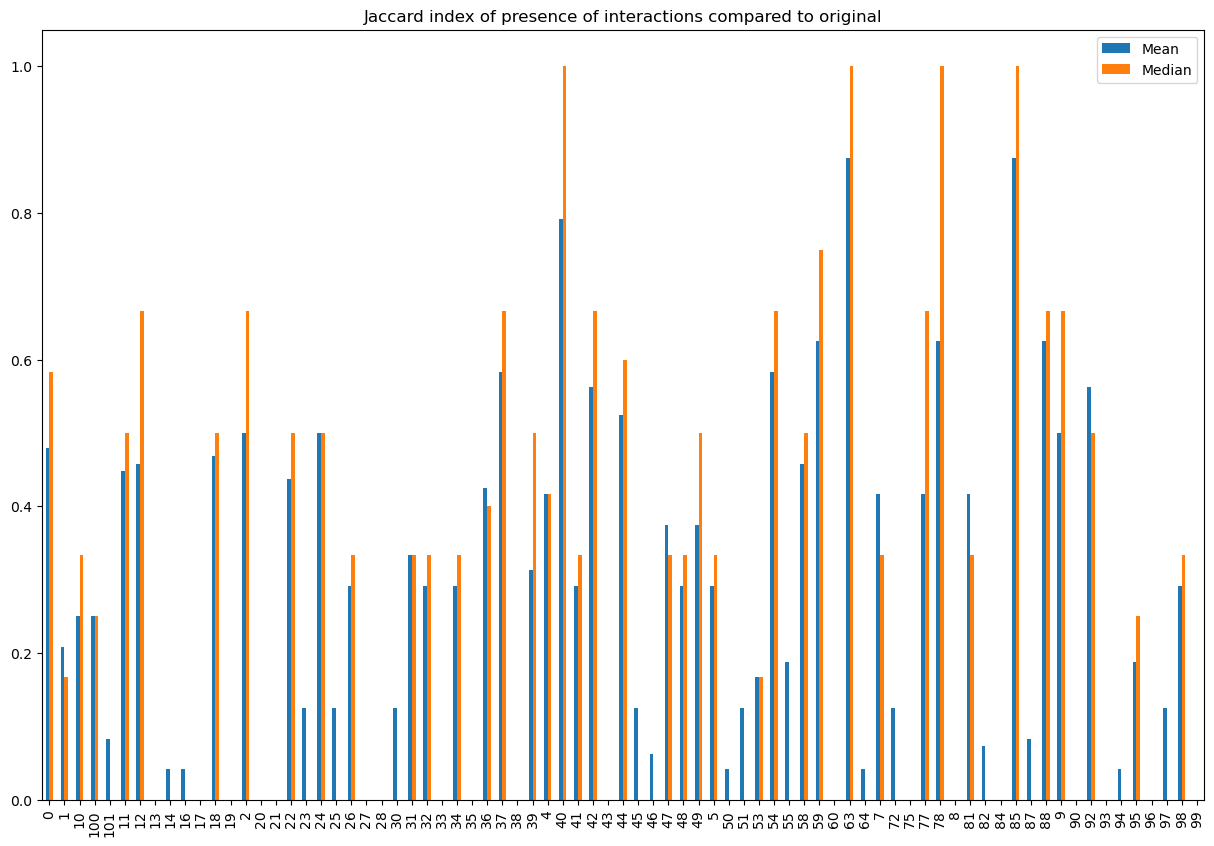

In [38]:
# Calculate mean, mode, and median of jaccard index value of ligand bitmap
bitmap_mean = df_jaccard_bitmap.mean(axis=0)
bitmap_mode = df_jaccard_bitmap.mode(axis=0)
bitmap_median = df_jaccard_bitmap.median(axis=0)
df_bitmap_plot = pds.concat([bitmap_mean, bitmap_median], axis=1)
df_bitmap_plot.columns = ['Mean', 'Median']
df_bitmap_plot = df_bitmap_plot.sort_index()
ax = df_bitmap_plot.plot.bar(figsize=(15,10), title='Jaccard index of presence of interactions compared to original')

In [30]:
fig_dir = Path('/home/pengs/fold_zika/figures')
fig = ax.get_figure()
fig.savefig(fig_dir/'plip_interaction_type.png')

## Make the map counting all interactions of ligand

In [25]:
# make interaction map by loop through the ligands
def make_lig_countmap(lig_prot_interactions):
    lig_inters = {}
    # Put this into a dictionary to use
    lig_inters = {}
    for inter in interactions:
        lig_inters[inter] = 0
        for interact_type in lig_prot_interactions:
            if interact_type == inter:
                lig_inters[interact_type] += 1
    return lig_inters

In [26]:
# Loop through ligands
orig_prot = 'zikv_ns2b3'
ligs = orig_interacts.keys()
prots = list(plip_all.keys())

# Getting a dictionary for making bitmap that counts each interactions of the proteins each ligand interact with
# Structure {lig1: prot1:{inter1:0, inter2:1,....},prot2:{inter1:0, inter2:0,....},...}
lig_prot_countmap = dict()
lig_prot_vec_countmap = dict() # Vectorized representation of lig_prot_map
for lig in ligs:
    lig_prot_countmap[lig] = dict()
    lig_prot_vec_countmap[lig] = dict()
    for prot in prots:
        prot_inters = ligand_interactions[lig][prot][2]
        inters_map = make_lig_countmap(prot_inters)
        lig_prot_countmap[lig][prot] = inters_map
        # Make each interactions into a vectorized bitmap
        lig_prot_vec_countmap[lig][prot] = np.array(pds.Series(inters_map))

In [27]:
lig_dist_jaccard = get_jaccard_distance(lig_prot_vec_countmap,orig_prot)
df_jaccard_countmap = pds.DataFrame(lig_dist_jaccard)
df_jaccard_countmap

,14,46,36,37,11,53,35,49,96,0,...,8,97,9,23,82,18,33,42,93,24
NP_776018.1,0.5,0.5,0.6,1.0,1.0,0.666667,0.5,0.5,0.000000,0.666667,...,0.333333,0.333333,1.0,0.666667,0.500000,1.0,0.666667,0.666667,0.666667,0.500000
YP_001527884.1,1.0,1.0,0.6,1.0,1.0,0.666667,0.5,0.5,0.000000,0.666667,...,0.333333,0.333333,1.0,0.666667,0.666667,0.5,0.666667,0.666667,0.333333,0.500000
YP_001531172.2,1.0,1.0,0.6,1.0,0.5,1.000000,0.0,0.5,0.000000,0.666667,...,0.333333,0.666667,1.0,0.666667,0.666667,0.5,0.666667,0.666667,0.666667,0.666667
NP_739587.2,0.5,1.0,0.6,1.0,1.0,1.000000,0.0,0.0,0.000000,0.666667,...,0.333333,1.000000,1.0,0.333333,0.666667,0.5,0.666667,0.666667,0.666667,0.666667
NP_722463.1,1.0,1.0,0.4,1.0,1.0,1.000000,0.0,0.0,0.000000,0.666667,...,0.333333,0.666667,1.0,0.666667,0.666667,0.5,0.666667,0.666667,0.666667,0.666667
NP_740321.1,1.0,1.0,0.6,1.0,1.0,0.666667,0.0,1.0,0.333333,1.000000,...,0.333333,0.000000,0.5,0.333333,0.666667,0.5,0.666667,0.666667,0.333333,0.500000
YP_001621843.1,1.0,1.0,0.8,1.0,1.0,1.000000,0.0,0.5,0.000000,0.666667,...,0.333333,0.666667,1.0,0.333333,0.333333,0.5,0.666667,0.500000,0.333333,0.500000
zikv_ns2b3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000


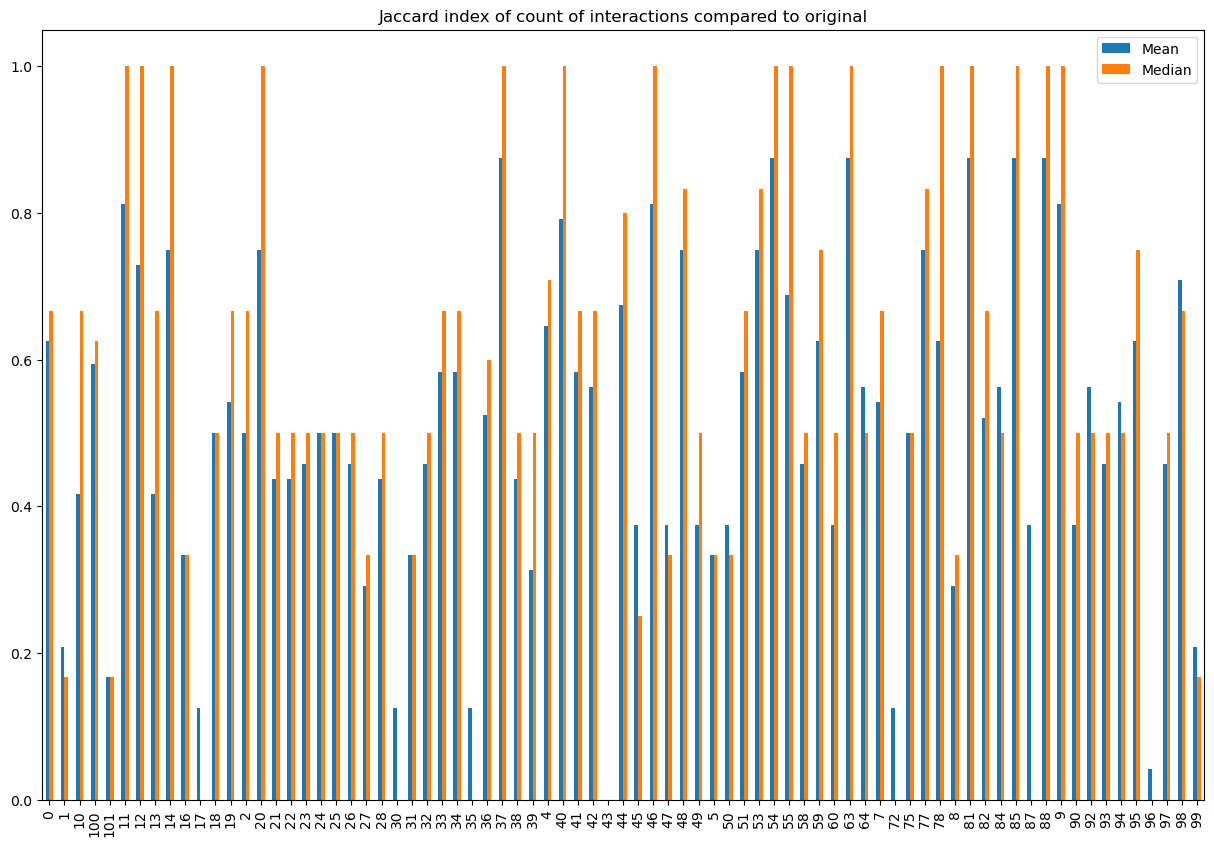

In [33]:
# Calculate mean, mode, and median of jaccard index value of ligand bitmap
countmap_mean = df_jaccard_countmap.mean(axis=0)
countmap_mode = df_jaccard_countmap.mode(axis=0)
countmap_median = df_jaccard_countmap.median(axis=0)
df_countmap_plot = pds.concat([countmap_mean, countmap_median], axis=1)
df_countmap_plot.columns = ['Mean', 'Median']
df_countmap_plot = df_countmap_plot.sort_index()
ax = df_countmap_plot.plot.bar(figsize=(15,10), title='Jaccard index of count of interactions compared to original')

In [34]:
fig_dir = Path('/home/pengs/fold_zika/figures')
fig = ax.get_figure()
fig.savefig(fig_dir/'plip_interaction_count.png')

## Plot fintscore distribution across ligands
https://github.com/choderalab/asapdiscovery/blob/main/asapdiscovery-data/asapdiscovery/data/metadata/fintscore_parameters.yaml

In [35]:
# Read in previously calculated Fint Scores
fint_oddt_docked = dict()
orig_fint = dict()

file_path = Path('/home/pengs/fold_zika/oddt_dock')

with open(file_path/'fint_oddt.json', 'r') as f:
    fint_oddt_docked = json.load(f)
with open(file_path/'orig_fint.json', 'r') as f:
    orig_fint = json.load(f)

### Plot the fint score of the ligands in original structure

In [36]:
df_orig = pds.DataFrame(orig_fint,index = ['intn_score', 'fint_score'])

In [37]:
df_orig_plot = df_orig.T
df_orig_plot = df_orig_plot.sort_index() 

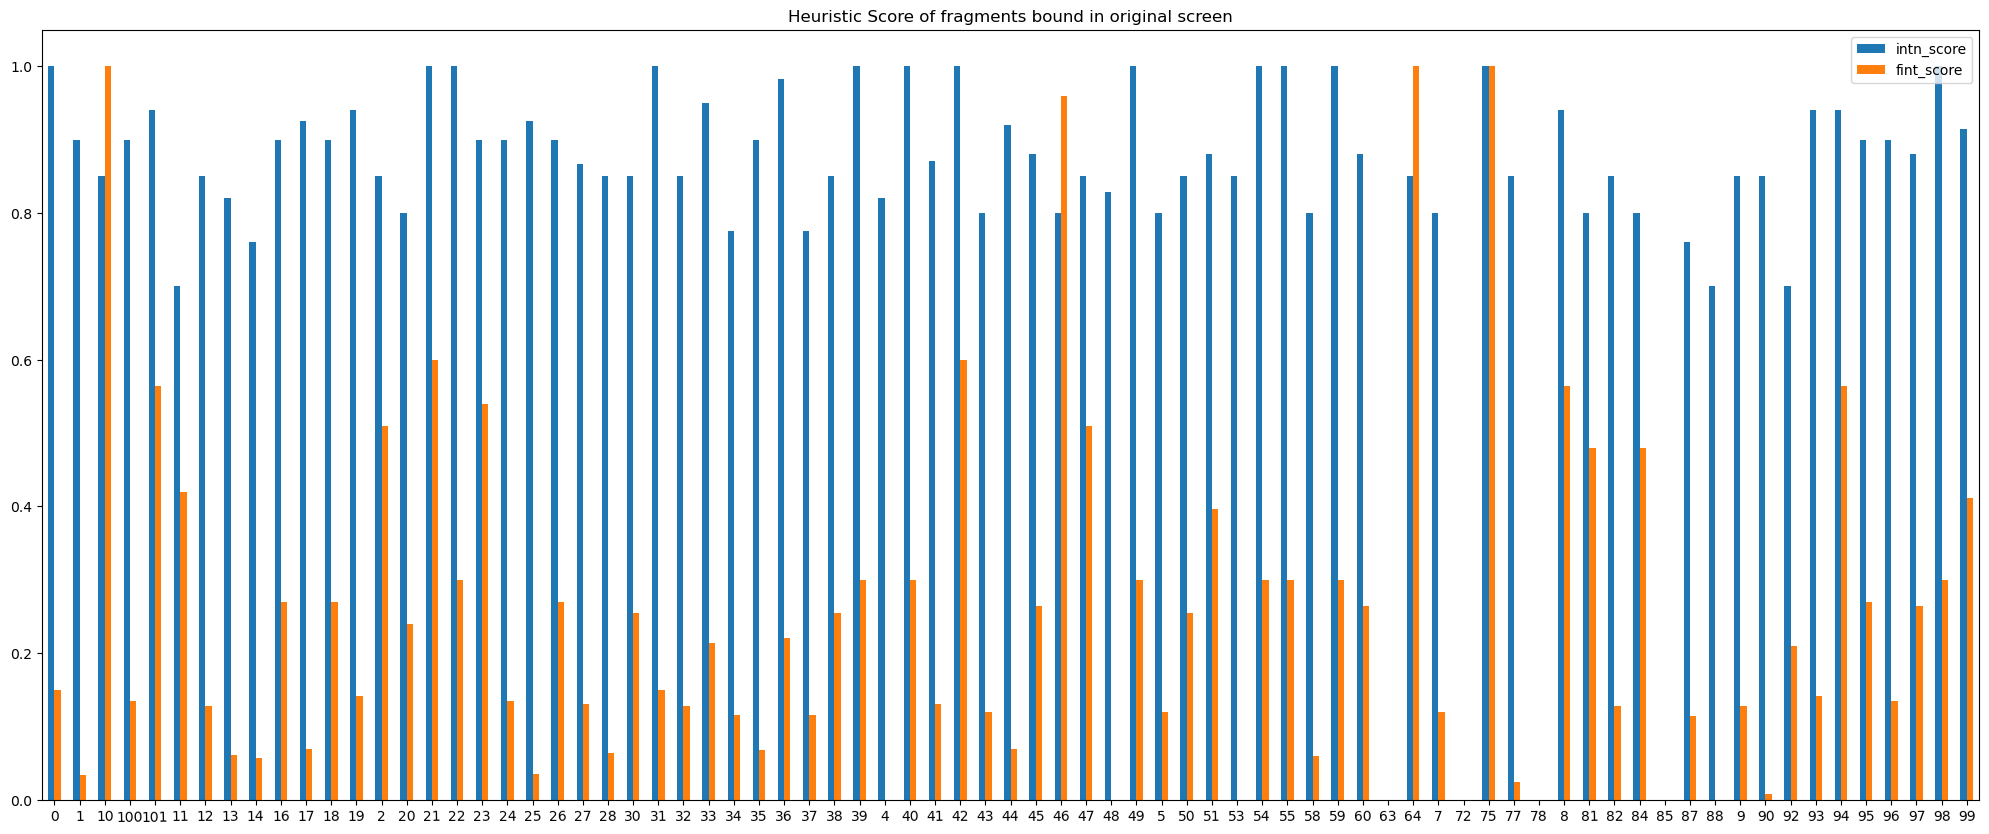

In [63]:
ax = df_orig_plot.plot.bar(rot=1,figsize=(25,10), title = 'Heuristic Score of fragments bound in original screen')

In [64]:
fig_dir = Path('/home/pengs/fold_zika/figures')
fig = ax.get_figure()
fig.savefig(fig_dir/'heuristic_scores_zikv_ns2b3.png')

## Calculate and get the combined score of fragment bound to all proteins identified

In [40]:
# Dictionary where each ligand 
#df_all = pds.DataFrame(fint_oddt_docked)
fint_oddt_docked_fint = dict()
fint_oddt_docked_intn = dict()

for prot in fint_oddt_docked:
    fint_oddt_docked_fint[prot] = dict()
    fint_oddt_docked_intn[prot] = dict()
    for lig in fint_oddt_docked[prot]:
        fint_oddt_docked_fint[prot][lig] = fint_oddt_docked[prot][lig][0]
        fint_oddt_docked_intn[prot][lig] = fint_oddt_docked[prot][lig][1]

In [41]:
df_fint = pds.DataFrame(fint_oddt_docked_fint)
df_intn = pds.DataFrame(fint_oddt_docked_intn)

In [42]:
df_fint['fint'] = df_fint.sum(axis=1, numeric_only=True)
df_intn['intn'] = df_intn.sum(axis=1, numeric_only=True)

In [43]:
df_intn_fint = pds.concat([df_intn['intn'], df_fint['fint']], axis = 1)
df_intn_fint = df_intn_fint.sort_index()

,NP_776018.1,YP_001527884.1,YP_001531172.2,NP_739587.2,NP_722463.1,NP_740321.1,YP_001621843.1,intn
17,0.564,0.564000,0.555,0.555,0.555,0.564000,0.555000,3.912000
11,0.420,0.000016,0.510,0.456,0.255,0.003164,0.480000,2.124180
75,1.000,1.000000,0.600,1.000,0.300,1.000000,1.000000,5.900000
97,0.555,0.555000,1.000,0.984,1.000,0.528000,0.492000,5.114000
100,1.000,0.560000,1.000,1.000,1.000,1.000000,1.000000,6.560000
...,...,...,...,...,...,...,...,...
31,0.540,0.540000,0.555,0.555,0.555,0.555000,0.600000,3.900000
63,0.600,1.000000,1.000,0.600,1.000,0.600000,1.000000,5.800000
9,0.480,0.480000,0.960,0.960,0.960,0.480000,0.942857,5.262857
24,0.564,0.564000,1.000,1.000,1.000,0.564000,0.564000,5.256000


In [45]:
df_all_intn = df_orig_plot['intn_score'].fillna(0) + df_intn['intn']
df_all_fint = df_orig_plot['fint_score'].fillna(0) + df_fint['fint']
df_all_scores = pds.concat([df_all_intn, df_all_fint], axis = 1)
df_all_scores = df_all_scores.sort_index() 
df_all_scores.columns = ['intn', 'fint']

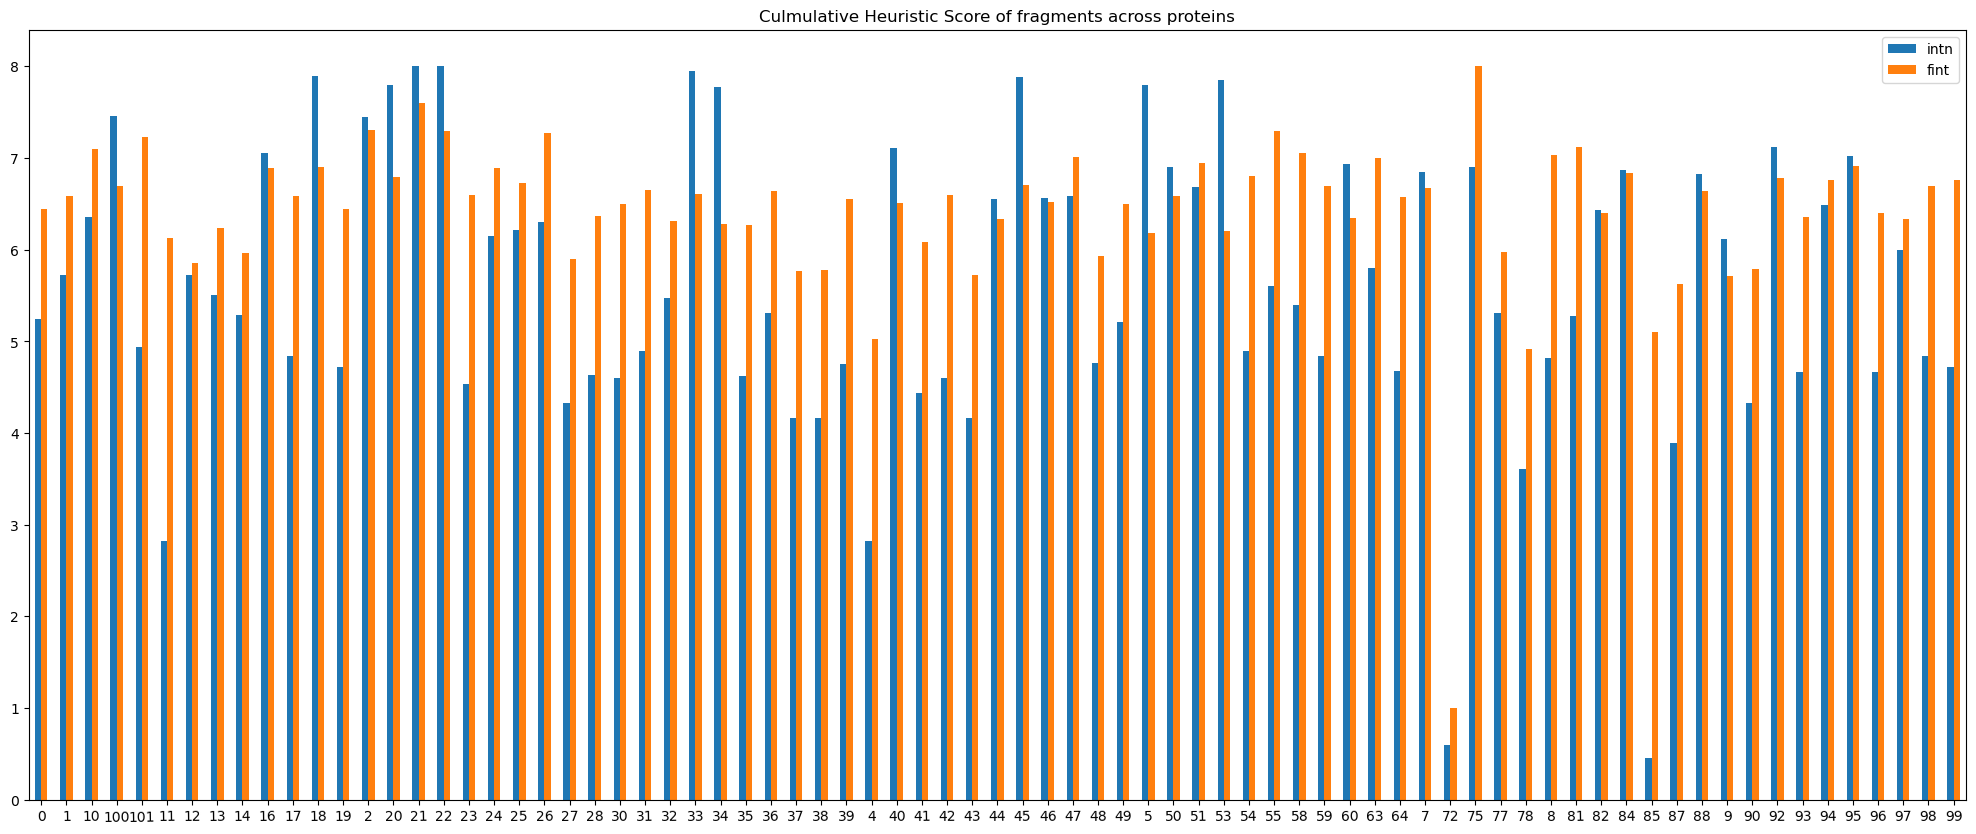

In [48]:
ax = df_all_scores.plot.bar(rot=1,figsize=(25,10), title = 'Culmulative Heuristic Score of fragments across proteins')

In [49]:
fig_dir = Path('/home/pengs/fold_zika/figures')
fig = ax.get_figure()
fig.savefig(fig_dir/'heuristic_scores_cumulative.png')

## RMSD for Ligand Poses
https://github.com/choderalab/asapdiscovery/blob/b325fdeb062924f4ccddf3e065aa47d444410681/asapdiscovery-docking/asapdiscovery/docking/analysis.py#L427

In [50]:
from asapdiscovery.docking.analysis import calculate_rmsd_openeye
import pandas as pds

In [51]:
ref_poses_dir = Path('/home/pengs/fold_zika/lig_sdfs')
pdb_poses_dir = Path('/home/pengs/fold_zika/oddt_dock/pose_pdbs')
prots_dir = Path('/home/pengs/fold_zika/only_prot')
target = 'ZIKV-NS2B-NS3pro'

In [52]:
# make a dictionary of RMSD difference between the new pose and X-ray chrystal structure
rmsd_pose_compare_ref = dict()

In [78]:
## Load in each of the reference ligand pose
## Keep this in a dictionary
ref_oe_ligs = dict()
lig_files = traverse_files(ref_poses_dir)
for lig_file in lig_files:
    lig_file_name = Path(lig_file).stem
    lig_num_pattern = r'lig_(\d+)'
    match = re.search(lig_num_pattern, lig_file_name)
    lig_name = match.group(1)
    ref_oe_ligs[lig_name] = load_openeye_sdf(ref_poses_dir/lig_file)

In [79]:
# Get a list of the protein that have information on
prot_files = traverse_files(prots_dir)
for prot_file in prot_files:
    prot = Path(prot_file).stem
    
    # get the list of files with the ligand in poses that are docked into the protein generated
    prot_lig_poses = traverse_files(pdb_poses_dir/prot)
    # If get to original structure, just skip it
    if len(prot_lig_poses) == 0:
        continue
    # Initiate dictionary to save rmsd comparison of the docked pose to original binding pose
    rmsd_pose_compare_ref[prot] = dict()
    # Go through poses
    for pose_file in prot_lig_poses:
        # Get the number of the ligand currently want to compare to
        lig_num_pattern = r'\d+_lig_(\d+).'
        match = re.search(lig_num_pattern, pose_file)
        lig_name = match.group(1)
        # Load in the new pose to oegraphmol structure
        new_pose = load_openeye_pdb(pdb_poses_dir/prot/pose_file)
        # caluclate how far off rmsd is from the 
        rmsd = calculate_rmsd_openeye(ref_oe_ligs[lig_name],new_pose)
        # Save into dictionary
        rmsd_pose_compare_ref[prot][lig_name] = rmsd

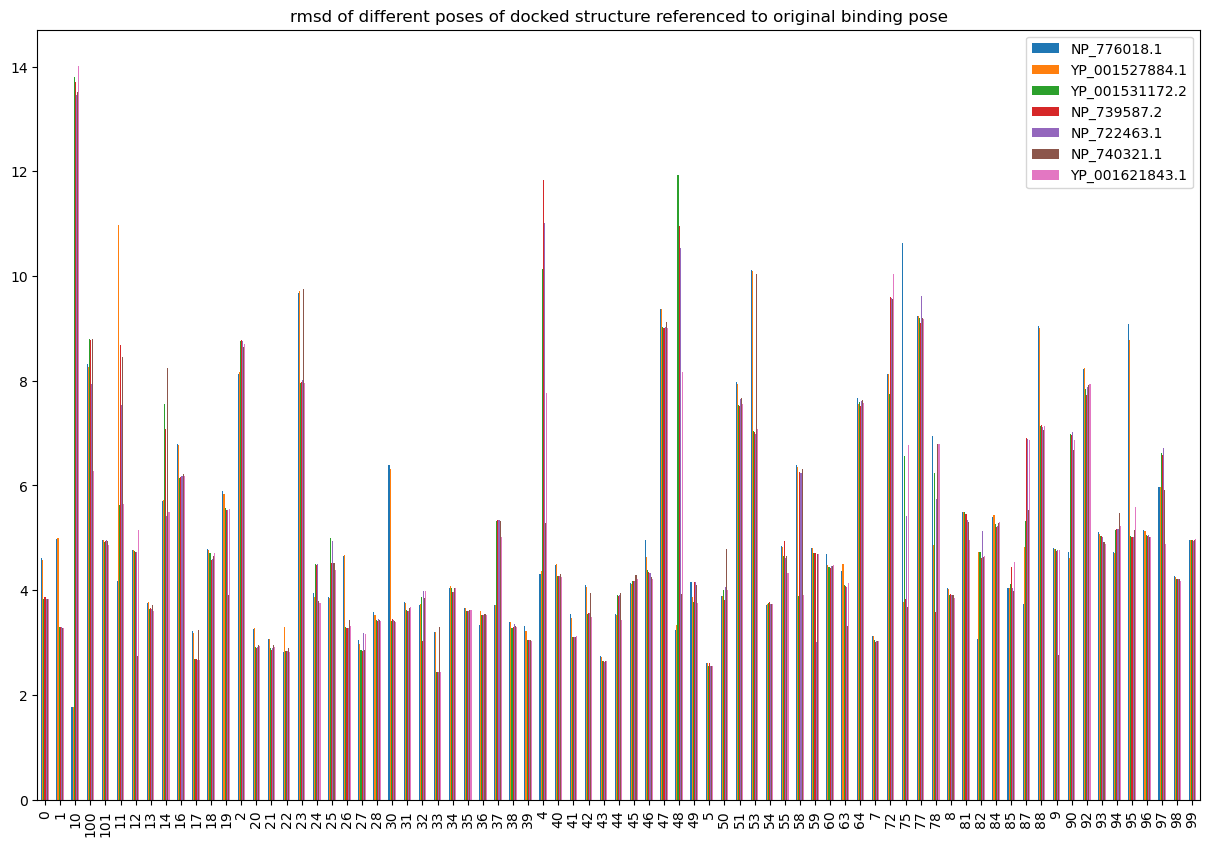

In [80]:
rmsd_df = pds.DataFrame(rmsd_pose_compare_ref).sort_index()
ax = rmsd_df.plot.bar(figsize=(15,10), title = 'rmsd of different poses of docked structure referenced to original binding pose')

In [81]:
fig = ax.get_figure()
fig.savefig(fig_dir/'rmsd_of_ligands_individual_proteins.png', dpi=300)

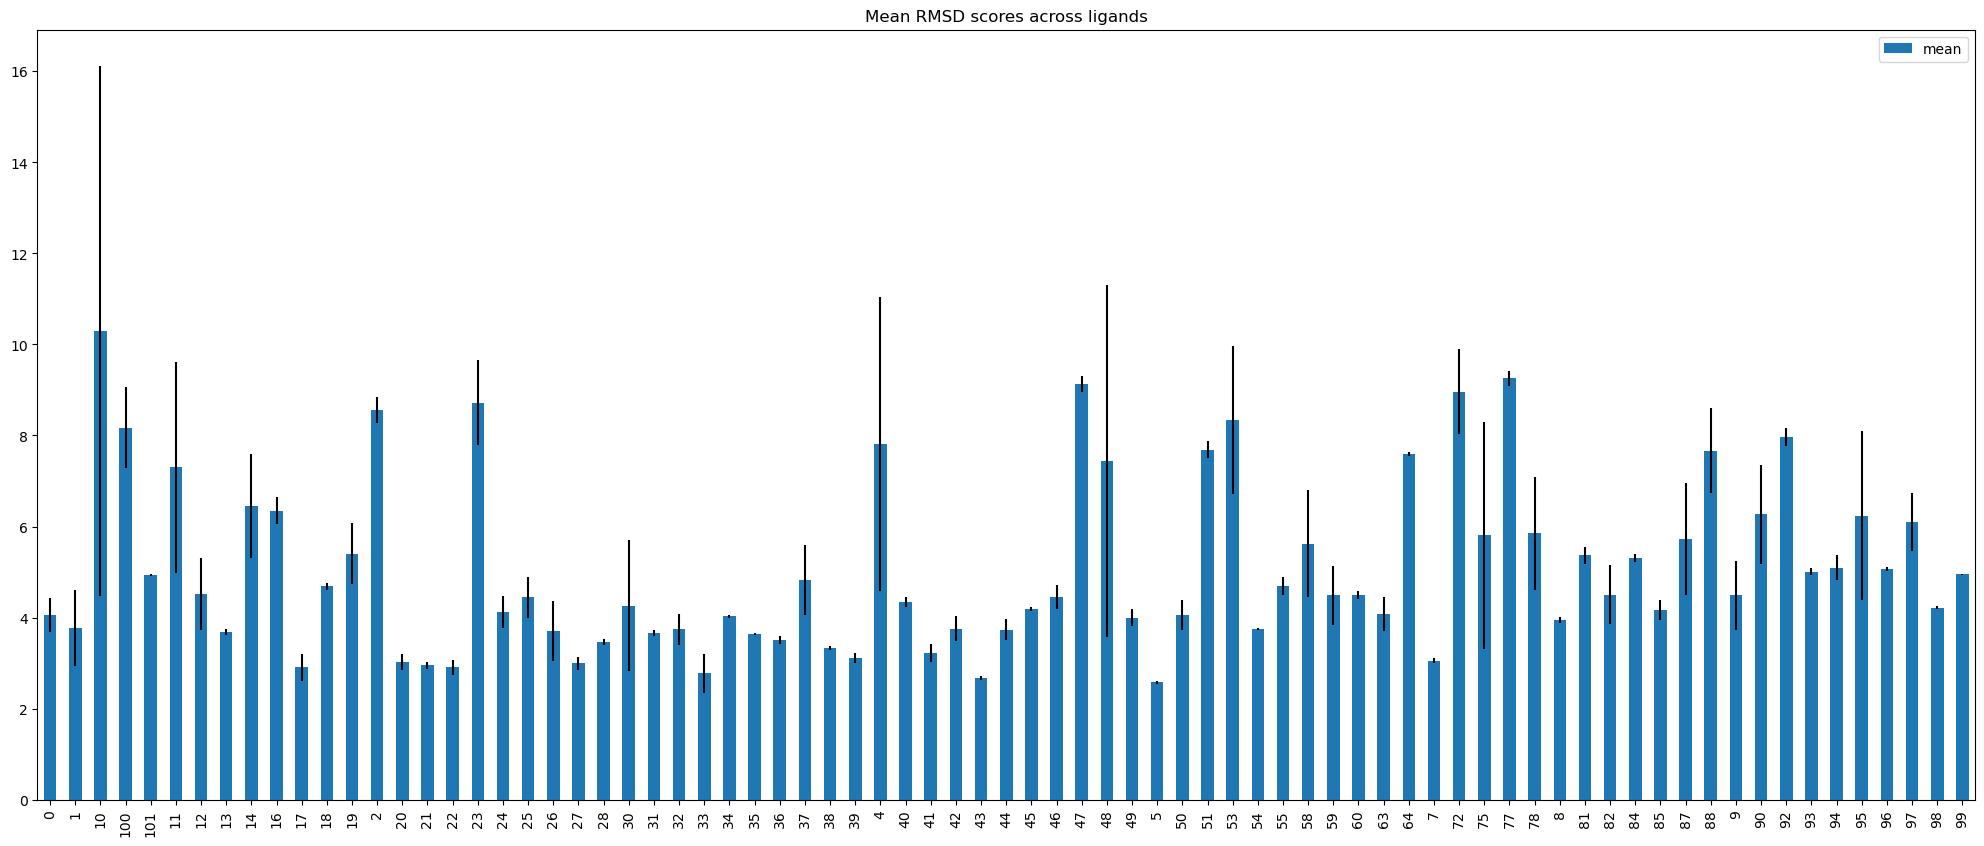

In [82]:
rmsd_summary = pds.DataFrame()
rmsd_summary['std'] = rmsd_df.std(axis=1) 
rmsd_summary['mean'] = rmsd_df.mean(axis=1)
rmsd_summary = rmsd_summary.sort_index()
ax = rmsd_summary.plot(kind = "bar", y = "mean",yerr = "std",figsize=(25,10), title = 'Mean RMSD scores across ligands')

In [83]:
fig = ax.get_figure()
fig.savefig(fig_dir/'rmsd_of_ligands.png', dpi=300)

## Get residue interactions from all generated poses

In [4]:
prots_dir = Path('/home/pengs/fold_zika/only_prot')
poses_dir = Path('/home/pengs/fold_zika/oddt_dock/output')
pdb_poses_dir = Path('/home/pengs/fold_zika/oddt_dock/all_pose_pdbs')
target = 'ZIKV-NS2B-NS3pro'

# Dictionary to save everything in
all_plip_oddt_docked = dict()

In [20]:
# Go through each protein
prot_files = traverse_files(prots_dir)
for prot_file in prot_files:
    # Protein name 
    name = Path(prot_file).stem
    # Initiate sub-dictionary for the protein
    all_plip_oddt_docked[name] = dict()
    
    # Directory with docked poses
    docked_dir = poses_dir/name
    save_pdb_dir = pdb_poses_dir/name
    print(docked_dir)
    #os.mkdir(save_pdb_dir)
    
    #Go through each ligand that start with '0_' becaust that is the one that has the best docking score
    lig_files = os.listdir(docked_dir)
    
    for lig_file in lig_files:
        # Save in dictionary with the number label the ligand with
        lig_num_pattern = r'(\d)_lig_(\d+).'
        match = re.search(lig_num_pattern, lig_file)
        lig_num = match.group(2)
        pose_num = match.group(1)

        ##TODO: GO THROUGH ALL GENERATED POSES
        # Make new dict if not already exist
        if lig_num in all_plip_oddt_docked[name]:
            continue
        else:
            all_plip_oddt_docked[name][lig_num] = dict()
        
        # Convert the pdbqt files to pdb to be read by openeye
        new_file = Path(lig_file).stem + '.pdb'
        cmd = f"cut -c-66 {docked_dir}/{lig_file} > {save_pdb_dir}/{new_file}"
        subprocess.run(cmd, shell=True)
        # Read in the pdb files to openeye to get plip
        prot = load_openeye_pdb(f'{prots_dir}/{prot_file}')
        lig = load_openeye_pdb(f'{save_pdb_dir}/{new_file}')
        # Get plip
        plip = get_interactions_plip(prot, lig, 'fitness',target)
        # Save this in the dictionary under the ligand name
        all_plip_oddt_docked[name][lig_num][pose_num] = plip

/home/pengs/fold_zika/oddt_dock/output/NP_776018.1


2024-04-09 13:28:51,419 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-09 13:28:51,420 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-09 13:28:51,420 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-09 13:28:51,420 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-09 13:28:51,486 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5239676.tmpdir/tmp6bbu0smp/
2024-04-09 13:28:52,328 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-09 13:28:52,329 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

/home/pengs/fold_zika/oddt_dock/output/YP_001527884.1


2024-04-09 13:30:08,574 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-09 13:30:08,575 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-09 13:30:08,575 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-09 13:30:08,576 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-09 13:30:08,639 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5239676.tmpdir/tmpah8s22fp/
2024-04-09 13:30:09,460 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-09 13:30:09,461 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

/home/pengs/fold_zika/oddt_dock/output/YP_001531172.2


2024-04-09 13:31:24,381 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-09 13:31:24,382 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-04-09 13:31:24,382 [INFO] [plipcmd.py:126] plip.plipcmd: please cite: Adasme,M. et al. PLIP 2021: expanding the scope of the protein-ligand interaction profiler to DNA and RNA. Nucl. Acids Res. (05 May 2021), gkab294. doi: 10.1093/nar/gkab294
2024-04-09 13:31:24,383 [INFO] [plipcmd.py:49] plip.plipcmd: starting analysis of tmp_complex.pdb
2024-04-09 13:31:24,446 [INFO] [plipcmd.py:165] plip.plipcmd: finished analysis, find the result files in /scratch/lsftmp/5239676.tmpdir/tmpdyu5jzav/
2024-04-09 13:31:25,263 [INFO] [plipcmd.py:124] plip.plipcmd: Protein-Ligand Interaction Profiler (PLIP) 2.3.0
2024-04-09 13:31:25,263 [INFO] [plipcmd.py:125] plip.plipcmd: brought to you by: PharmAI GmbH (2020-2021) - www.pharm.ai - hello@pharm.ai
2024-0

/home/pengs/fold_zika/oddt_dock/output/zikv_ns2b3


FileNotFoundError: [Errno 2] No such file or directory: '/home/pengs/fold_zika/oddt_dock/output/zikv_ns2b3'

In [21]:
all_plip_oddt_docked.keys()

dict_keys(['NP_776018.1', 'YP_001527884.1', 'YP_001531172.2', 'zikv_ns2b3', 'NP_739587.2', 'NP_722463.1', 'NP_740321.1', 'YP_001621843.1'])

In [22]:
with open('/home/pengs/fold_zika/oddt_dock/all_plip_docked.json', 'w') as f:
    json.dump(all_plip_oddt_docked,f)

## Save generated scores into one csv

In [84]:
all_scores = pds.DataFrame()
all_scores['rmsd_mean'] = rmsd_summary['mean']
all_scores['interaction_jaccard_mean'] = bitmap_mean 
all_scores['interactions_count_jaccard_mean'] = countmap_mean
all_scores['fint'] = df_all_scores['fint']
all_scores['intn'] = df_all_scores['intn']

In [85]:
all_scores

,rmsd_mean,interaction_jaccard_mean,interactions_count_jaccard_mean,fint,intn
0,4.055237,0.479167,0.625000,6.450000,5.240000
1,3.770930,0.208333,0.208333,6.583750,5.720000
10,10.287188,0.250000,0.416667,7.100000,6.360000
100,8.169316,0.250000,0.593750,6.696905,7.460000
101,4.934367,0.083333,0.166667,7.234000,4.942000
...,...,...,...,...,...
95,6.241929,0.187500,0.625000,6.915000,7.028000
96,5.066051,0.000000,0.041667,6.406429,4.662857
97,6.094942,0.125000,0.458333,6.334000,5.994000
98,4.218546,0.291667,0.708333,6.700000,4.840000


In [86]:
filepath = '/home/pengs/fold_zika/compare_scores.csv'
all_scores.to_csv(filepath)

## Try to see if some poses are actually more similar to original than others

In [ ]:
all_plip_oddt_docked = dict()
with open('/home/pengs/fold_zika/oddt_dock/all_plip_docked.json', 'r') as f:
    all_plip_oddt_docked = json.load(f)